In [1]:
import json
import glob
from pathlib import Path
import random
from copy import deepcopy
import pprint
import collections
import matplotlib.pyplot as plt
import re
from collections import Counter
from openai import OpenAI
import concurrent.futures
import copy
import os
import sys
from datetime import datetime

In [2]:
sys.path.append('/Users/hsx66/Workspace/llm_agents/StableToolBench/toolbench/tooleval/')

In [3]:
os.environ["API_POOL_FILE"] = "./openai_key.json"
os.environ["EVAL_MODEL"] = "gpt-4o-2024-08-06"

In [128]:
def react_parser(string):
    if 'Thought:' in string and "Action:" in string and "Action Input:" in string:
        thought = [string[string.find("Thought:") + len("Thought:"): string.find("Action:")]]
        action = [string[string.find("Action:") + len("Action:"): string.find("Action Input:")]]
        action_input = [string[string.find("Action Input:") + len("Action Input:"):]]
        return thought[0].strip(), action[0].strip(), action_input[0].strip()
    elif 'Thought:' not in string and "Action:" in string and "Action Input:" in string:
        thought = [string[: string.find("Action:")]]
        action = [string[string.find("Action:") + len("Action:"): string.find("Action Input:")]]
        action_input = [string[string.find("Action Input:") + len("Action Input:"):]]
        return thought[0].strip(), action[0].strip(), action_input[0].strip()
    else:
        # pdb.set_trace()
        return string, "", ""
    
def new_react_parser(string):
    action_input_idx = string.find("Action Input:")
    if action_input_idx == -1:
        return string, "", ""
    
    action_idx = string.rfind("Action:", 0, action_input_idx)
    
    if action_idx == -1:
        return string[:action_input_idx].strip(), "", string[action_input_idx + len("Action Input:"):].strip()
    
    thought = string[:action_idx].strip()
    action = string[action_idx + len("Action:"):action_input_idx].strip()
    action_input = string[action_input_idx + len("Action Input:"):].strip()
    
    return thought, action, action_input

In [5]:
from evaluators import load_registered_automatic_evaluator

In [6]:
evaluator = load_registered_automatic_evaluator(evaluator_name="tooleval_gpt-3.5-turbo_default", evaluators_cfg_path="/Users/hsx66/Workspace/llm_agents/StableToolBench/toolbench/tooleval/evaluators")

In [234]:
model_name = "fqwen_rely_sft"
model_base = 'llama3' if 'llama3' in model_name else 'qwen2'

In [235]:
sampling_output_path = Path(f"/Users/hsx66/Workspace/llm_agents/StableToolBench/sampling_data/sampling_{model_base}/{model_name}")

In [236]:
sampling_outputs = {}
for p in list(sampling_output_path.glob("**/*.json")): 
    with open(p, 'r') as f:
        output_data = json.load(f)
    sampling_outputs[p.name] = output_data

In [237]:
len(sampling_outputs)

12000

In [238]:
list(sampling_outputs.values())[100]

{'win': True,
 'try_count': 1,
 'trys': [{'chain': [{'is_terminal': False,
     'pruned': False,
     'finished': False,
     'depth': 1,
     'node_type': 'Thought',
     'description': '\nThought:  \nAction: list_of_available_currencies_for_changenow_crypto_exchange\nAction Input: {}',
     'Elo': 1000.0,
     'child_count': 1,
     'expand_num': 0},
    {'is_terminal': False,
     'pruned': False,
     'finished': False,
     'depth': 2,
     'node_type': 'Action',
     'description': 'list_of_available_currencies_for_changenow_crypto_exchange',
     'Elo': 1000.0,
     'child_count': 1,
     'expand_num': 0},
    {'is_terminal': False,
     'pruned': False,
     'finished': False,
     'depth': 3,
     'node_type': 'Action Input',
     'description': '{}',
     'Elo': 1000.0,
     'observation': '{"error": "", "response": "The \'List of available currencies\' API endpoint provides a comprehensive list of cryptocurrencies and fiat currencies available for transactions. Each currency

In [195]:
same_func_calling_num = 0
same_func_name_num = 0
diff_num = 0

for p, sampling_output in sampling_outputs.items():
    try:
        message = sampling_output['answer_generation']['last_node_messages'][-1]
        outputs = sampling_output['sampling_outputs']
        assert len(outputs) == len([1 for i in message if i['role'] == 'assistant'])
        for turn_outputs in outputs:
            parsed_outputs = [react_parser(output) for output in turn_outputs]
            if len(set([i[1] for i in parsed_outputs])) == 1:
                if parsed_outputs[0][1] == 'Finish':
                    continue
                if len(set([i[2] for i in parsed_outputs])) == 1:
                    same_func_calling_num += 1
                else:
                    same_func_name_num += 1
            else:
                diff_num += 1
        
    except Exception as e:
        print(e)
        print(sampling_output)
        break
print(f'Number of sampling results with same function calling / same function name / differenct function name', same_func_calling_num, same_func_name_num, diff_num)

Number of sampling results with same function calling / same function name / differenct function name 13719 3059 12768


In [196]:
def check_type(variable, type_str):
    type_mapping = {
        "string": "str",
        "integer": "int",
        "int": "int",
        "float": "float",
        "boolean": "bool",
        "bool": "bool",
        "list": "list",
        "tuple": "tuple",
        "dict": "dict",
        "dictionary": "dict",
        "set": "set",
        "none": "type(None)",
        "noneType": "type(None)",
    }
    type_str = type_str.strip().lower()

    if type_str in type_mapping:
        return isinstance(variable, eval(type_mapping[type_str]))
    else:
        return False

def check_hallucination_reason(node, name_to_available_tool,
                               user_history,
                               tool_calling_history,
                               return_reason=False)->bool:
    # if isinstance(node_message, dict):
    #     node_message = str(node_message)
    # name = re.findall(r"'name':\s*'(.*?)'", node_message, re.DOTALL)[0]
    tool_name = node['name']
    if tool_name not in name_to_available_tool.keys():
        return "tool_name_hallucination"


    golden_tool = name_to_available_tool[tool_name]
    golden_tool_parameter = golden_tool['parameters']

    # tool_suitability = AnswerStatus(ret['tool_suitability'])
#     if tool_relevance != None and tool_relevance != "Relevant" and tool_relevance[tool_name] == "Irrelevant":
#         return "tool_relevance_hallucination"

    for his in tool_calling_history:
        if node['name'] == his['name'] and node['arguments'] == his['arguments']:
                return "tool_duplicated_hallucination"

    try:
        tool_invocation = json.loads(node['arguments'])
    except:
        return "parameter_json_format_hallucination"

    for required_para in golden_tool_parameter['required']:
        if required_para != '' and required_para not in tool_invocation.keys():
            return "parameter_required_missing"
    for para in tool_invocation.keys():
        if tool_name == 'Finish':
            golden_tool_parameter['optional'] = ['final_answer']
        if para not in golden_tool_parameter['required'] + golden_tool_parameter['optional']:
            return "parameter_name_hallucination"
    for para in tool_invocation.keys():
        para_value = tool_invocation[para]
        golden_para_type = golden_tool_parameter['properties'][para]['type']
        if not check_type(para_value, golden_para_type):
            return "parameter_value_type_error"

    if len(tool_invocation) > 0 and tool_name != 'Finish':
        ret = evaluator.function_call(
            'evaluate_calling_truthfulness',
            {
                'user_history': user_history,
                'tool_parameter': golden_tool_parameter,
                'tool_calling': tool_invocation
            },
            return_reason=return_reason
        )
        if ret['calling_trufulness'] == 'Untruthful':
            return "parameter_value_hallucination"
    if tool_name == 'Finish':
        return "no_hallucination_finish"
    else:
        return "no_hallucination"

In [197]:
all_submitted_tasks = []
for p, sampling_output in list(sampling_outputs.items()):
    #print(p)
    message = sampling_output['answer_generation']['last_node_messages'][-1]
    query = sampling_output['answer_generation']['query']
    outputs = sampling_output['sampling_outputs']
    assert len(outputs) == len([1 for i in message if i['role'] == 'assistant'])
    available_tools = sampling_output['answer_generation']['function']
    name_to_available_tool = {tool['function']['name']: tool['function']  for tool in available_tools}
    user_history = f"User: {query}\n"
    assis_turn_idx = 0
    tool_calling_history = []
    
    for m in message:
        if m['role'] == 'assistant':
            all_responses = [m['content']] + outputs[assis_turn_idx]
            all_nodes = {}
            all_node_values = []
            
            for i, response in enumerate(all_responses):
                parsed_res = react_parser(response)
                node_value = {'name': parsed_res[1], 'arguments': parsed_res[2]}
                if node_value in all_node_values:
                    continue
                else:
                    all_node_values.append(node_value)
                    all_nodes[i] = node_value
            
            for i, node in all_nodes.items():
                    #print(check_hallucination_reason(node, name_to_available_tool, user_history, tool_calling_history))
                all_submitted_tasks.append({'p': p, 'assis_turn_idx': assis_turn_idx, 'node_idx': i, \
                                            'task_input': {'node':node, 'name_to_available_tool': name_to_available_tool, 'user_history': user_history, 'tool_calling_history': list(tool_calling_history)}})

            
            if len(set([i['name'] for i in all_node_values])) == 1 \
                and (len(set([i['arguments'] for i in all_node_values])) == 1 or 'Finish' in set([i['name'] for i in all_node_values])):
                # print(f'invalid function sampling:\n{all_node_values}')
                pass
            else:
                pass
                # print(f'function sampling:\n{all_node_values}')                    
            parsed_res = react_parser(m['content'])
            tool_calling_history.append({'name': parsed_res[1], 'arguments': parsed_res[2]})
            assis_turn_idx += 1

In [198]:
print(len(all_submitted_tasks))

174005


In [243]:
all_submitted_tasks = sampling_hallucination_results

In [245]:
for i in sampling_hallucination_results:
    if 'hallucination' not in i:
        print(111)

In [204]:
def get_openai_outputs(task):
    global completed_num
    task_input = task['task_input']
    if 'hallucination' in task:
        completed_num += 1
        return task
    output = check_hallucination_reason(**task_input)
    if output is not None:
        task['hallucination'] = output
        completed_num += 1
        if completed_num % 1000 == 0:
            print(datetime.now(), completed_num)
    return task

In [205]:
global completed_num
completed_num = 0

In [206]:
while completed_num < len(all_submitted_tasks):
    with concurrent.futures.ThreadPoolExecutor(max_workers=100) as executor:
        results = executor.map(get_openai_outputs, all_submitted_tasks)

In [239]:
model_name

'fqwen_rely_sft'

In [210]:
with open(f'sampling_hallucination_results/{model_name}_all_split.json', 'w') as f:
    json.dump(all_submitted_tasks, f, indent=4)

In [240]:
model_name = "fqwen_rely_sft"
model_base = 'llama3' if 'llama3' in model_name else 'qwen2'
sampling_output_path = Path(f"/Users/hsx66/Workspace/llm_agents/StableToolBench/sampling_data/sampling_{model_base}/{model_name}")

In [241]:
with open(f'sampling_hallucination_results/{model_name}_all_split.json', 'r') as f:
    sampling_hallucination_results = json.load(f)

In [242]:
len(sampling_hallucination_results)

175372

In [266]:
turn_results = {}

In [267]:
jump_sum = 0
for res in sampling_hallucination_results:
    p = res['p']
    assis_turn_idx = res['assis_turn_idx']
    func_name = res['task_input']['node']['name']
    k = f'{p}_{assis_turn_idx}'
    if 'hallucination' not in res:
        jump_sum += 1
        continue
    if func_name == 'Finish' and res['hallucination'] == 'no_hallucination':
        hallu = 'no_hallucination_finish'
    else:
        hallu = res['hallucination']
    if k not in turn_results:
        turn_results[k] = [(func_name, hallu, assis_turn_idx, p)]
    else:
        turn_results[k].append((func_name, hallu, assis_turn_idx, p))
print(f'jump {jump_sum} instances')


jump 0 instances


In [268]:
print(len(turn_results))

38654


In [269]:
no_hallu_num = 0
finish_num = 0
hallu_num = 0
all_hallu_num = 0
all_hallu_turn_idx = []
all_dpo_pids = []
for v in turn_results.values():
    #print(v)
    if all([i[0] =='Finish' for i in v]):
        finish_num += 1
    elif all([i[1] =='no_hallucination' for i in v]):
        #print(v)
        no_hallu_num += 1
    elif all([not i[1].startswith('no_hallucination')for i in v]):
        all_hallu_num += 1
    else:
        hallu_num += 1
        all_hallu_turn_idx.append(v[0][2] + 1)
        all_dpo_pids.append(v[0][3])
print("Number of sampling steps with no hallucination / all_hallucination / both hallucination and no hallucination", no_hallu_num, all_hallu_num, hallu_num)
print(f"{len(all_dpo_pids)} DPO data points from {len(set(all_dpo_pids))} prompts(tasks)")

Number of sampling steps with no hallucination / all_hallucination / both hallucination and no hallucination 15192 3605 10502
10502 DPO data points from 6321 prompts(tasks)


# Plot DPO data step distribution

In [270]:
from collections import Counter

In [271]:
count = Counter(all_hallu_turn_idx)

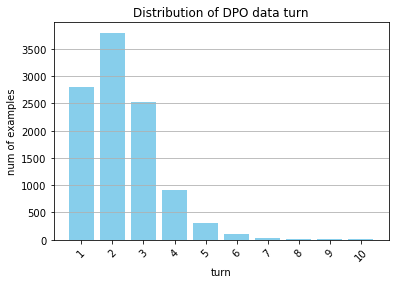

In [272]:
bins = list(range(1, 10)) + [10]  # 1-9 每个数字一个柱子，10为大于等于10的合并柱子
counts = [count[i] for i in bins[:-1]]  # 1-9 的计数
counts.append(sum(count[i] for i in range(10, 101)))  # 大于等于10的计数

# 绘制直方图
plt.bar([str(i) for i in bins], counts, color='skyblue')
plt.xlabel('turn')
plt.ylabel('num of examples')
plt.title('Distribution of DPO data turn')
plt.xticks(rotation=45)
plt.grid(axis='y')

# 显示图表
plt.show()

In [273]:
qid_to_res = {}
for task in sampling_hallucination_results:
    task_qid = task['p']
    task_assis_turn_idx = task['assis_turn_idx']
    task_node_idx = task['node_idx']
    if 'hallucination' not in task:
        continue
    task_hallucination = task['hallucination']
    if task_qid not in qid_to_res:
        qid_to_res[task_qid] = {task_assis_turn_idx: {task_node_idx: task_hallucination}}
    elif task_assis_turn_idx not in qid_to_res[task_qid]:
        qid_to_res[task_qid][task_assis_turn_idx] = {task_node_idx: task_hallucination}
    else:
        qid_to_res[task_qid][task_assis_turn_idx][task_node_idx] = task_hallucination

In [274]:
def process_system_message(system_message, functions):
    assert "with a function call to actually excute your step." in system_message
    # we find that following ReACT format and merging the thought node and function call node is easier for model to learn to integrate the action input json string in its prediction than learn to predict a json string directly.
    system_message = system_message.replace("with a function call to actually excute your step.", "with a function call to actually excute your step. Your output should follow this format:\nThought:\nAction:\nAction Input:\n")
    # add all the function dicts in the prompt.
    system_message = system_message + "\nSpecifically, you have access to the following APIs: " + str(functions)
    return system_message

In [275]:
len(sampling_hallucination_results)

175372

In [276]:
valid_turns = 0
valid_no_better_reject_turns = 0
valid_no_better_hallu_turns = 0
valid_reject_better_hallu_turns = 0


all_dpo_data = []
all_dpo_funcs = []
for p, sampling_output in list(sampling_outputs.items()):
    message = sampling_output['answer_generation']['last_node_messages'][-1]
    query = sampling_output['answer_generation']['query']
    outputs = sampling_output['sampling_outputs']
    assert len(outputs) == len([1 for i in message if i['role'] == 'assistant'])
    available_tools = sampling_output['answer_generation']['function']
    name_to_available_tool = {tool['function']['name']: tool['function']  for tool in available_tools}
    user_history = f"User: {query}\n"
    assis_turn_idx = 0
    tool_calling_history = []
    
    dialogue_history = []
    for m in message:
        if m['role'] == 'assistant':
            all_responses = [m['content']] + outputs[assis_turn_idx]
            all_nodes = {}
            all_node_values = []
            all_node_responses = {}
            
            for i, response in enumerate(all_responses):
                parsed_res = react_parser(response)
                node_value = {'name': parsed_res[1], 'arguments': parsed_res[2]}
                
                if node_value in all_node_values:
                    continue
                else:
                    all_node_values.append(node_value)
                    all_nodes[i] = node_value
                    all_node_responses[i] = response
                all_nodes[i] = node_value
                    
            
            if len(set([i['name'] for i in all_node_values])) == 1 \
                and (len(set([i['arguments'] for i in all_node_values])) == 1 or 'Finish' in set([i['name'] for i in all_node_values])):
                # print(f'invalid function sampling:\n{all_node_values}')
                pass
            else:
                #print(qid_to_res[p])
                #print(len(qid_to_res[p][assis_turn_idx]), len(all_nodes))
                if assis_turn_idx not in qid_to_res[p]:
                    print('jump')
                    continue
                if len(qid_to_res[p][assis_turn_idx]) != len(all_nodes):
                    print(111)
                turn_res = copy.deepcopy(qid_to_res[p][assis_turn_idx])
                for i, node_value in all_nodes.items():
                    #print(i, node_value)
                    if node_value['name'] == '':
                        try:
                            turn_res.pop(i)
                        except:
                            pass
                    if new_react_parser(all_node_responses[i])[1] == 'Finish':
#                         if i in turn_res and turn_res[i] != 'no_hallucination':
#                             print(f'fixed from {turn_res[i]} to no_hallucination_finish')
                        turn_res[i] = 'no_hallucination_finish'
                turn_hallucinations = list(turn_res.values())
                
                if ('no_hallucination' in turn_hallucinations or 'no_hallucination_finish' in turn_hallucinations) and len(set(turn_hallucinations)) > 1:
                    no_hallu_list = list(filter(lambda x: turn_res[x] == 'no_hallucination', turn_res.keys()))
                    finish_list = list(filter(lambda x: turn_res[x] == 'no_hallucination_finish', turn_res.keys()))
                    hallucinated_list = list(filter(lambda x: turn_res[x] not in ['no_hallucination', 'no_hallucination_finish'] , turn_res.keys()))
                    if len(no_hallu_list) > 0:
                        no_hallucinated_idx = random.choice(no_hallu_list)
                    else:
                        no_hallucinated_idx = None
                    
                    if len(finish_list) > 0:
                        no_hallucinated_finish_idx = random.choice(finish_list)
                    else:
                        no_hallucinated_finish_idx = None
                    if len(hallucinated_list) > 0:
                        hallucinated_idx = random.choice(hallucinated_list)
                    else:
                        hallucinated_idx = None
                    #print(no_hallu_list, finish_list, hallucinated_list)
                    
                    if no_hallucinated_idx is not None and no_hallucinated_finish_idx is not None:
                                            
                        chosen = all_responses[no_hallucinated_idx]
                        rejected = all_responses[no_hallucinated_finish_idx]
                        dpo_data = dialogue_history + [{"role": "assistant", "content": '', 'chosen': chosen,
                                                       'rejected': rejected}]
                        all_dpo_data.append({'id': '', 'conversations': dpo_data})
                        valid_turns += 1
                        valid_no_better_reject_turns += 1
                        #print(turn_res)
                        #print(all_responses)
                        
                        if 'Action: Finish' in chosen and 'Action: Finish' in rejected:
                            
                            print('111*************************chosen*************************')
                            print(chosen)
                            print('*************************rejected*************************')
                            print(rejected)
                            print('\n\n')
                    if no_hallucinated_idx is not None and hallucinated_idx is not None:
                                            
                        chosen = all_responses[no_hallucinated_idx]
                        rejected = all_responses[hallucinated_idx]
                        dpo_data = dialogue_history + [{"role": "assistant", "content": '', 'chosen': chosen,
                                                       'rejected': rejected}]
                        all_dpo_data.append({'id': '', 'conversations': dpo_data})
                        valid_turns += 1
                        valid_no_better_hallu_turns += 1
                        #all_dpo_funcs.append((all_nodes[no_hallucinated_idx]['name'], all_nodes[hallucinated_idx]['name'], qid_to_res[p][assis_turn_idx][hallucinated_idx]))
                    if no_hallucinated_finish_idx is not None and hallucinated_idx is not None:
                        #all_dpo_funcs.append((all_nodes[no_hallucinated_idx]['name'], all_nodes[hallucinated_idx]['name'], qid_to_res[p][assis_turn_idx][hallucinated_idx]))
                        chosen = all_responses[no_hallucinated_finish_idx]
                        rejected = all_responses[hallucinated_idx]
                        dpo_data = dialogue_history + [{"role": "assistant", "content": '', 'chosen': all_responses[no_hallucinated_finish_idx],
                                                       'rejected': all_responses[hallucinated_idx]}]
                        all_dpo_data.append({'id': '', 'conversations': dpo_data})
                        valid_turns += 1
                        valid_reject_better_hallu_turns += 1
    
                    
            parsed_res = react_parser(m['content'])
            tool_calling_history.append({'name': parsed_res[1], 'arguments': parsed_res[2]})
            assis_turn_idx += 1
        if m['role'] == 'system':
            dialogue_history.append({'role': 'system', 'content': process_system_message(m['content'], available_tools)})
        else:
            dialogue_history.append(m)

In [277]:
print(valid_turns, valid_no_better_reject_turns, valid_no_better_hallu_turns, valid_reject_better_hallu_turns)

14079 3654 6028 4397


In [278]:
print(len(all_dpo_data))

14079


In [279]:
os.makedirs(f'/Users/hsx66/Workspace/llm_agents/agent_tuning/agent_data_dir/{model_base}_reliable_dpo_data/{model_name}', exist_ok=True)

In [280]:
with open(f'/Users/hsx66/Workspace/llm_agents/agent_tuning/agent_data_dir/{model_base}_reliable_dpo_data/{model_name}/dpo_1w.json', 'w') as f:
    json.dump(all_dpo_data, f, indent=4)